# Relax challenge

In [432]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.base import MultiOutputMixin
from sklearn import metrics
%matplotlib inline

In [334]:
!ls

GH_relax_challenge.ipynb         takehome_user_engagement.csv
Log_ROC.png                      takehome_users.csv
relax_data_science_challenge.pdf


In [335]:
#read in the data
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')

In [336]:
user_engagement_df[user_engagement_df.user_id == 2]

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1
10,2014-02-13 03:45:04,2,1


In [337]:
user_engagement_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [338]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [339]:
#load in the data
users_df = pd.read_csv('takehome_users.csv', encoding="latin")
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [340]:
users_df.tail()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,NaN


Looks like 'time_stamp' from user_engagement_df and 'creation_time' from  users_df need to be converted to datetime format. 'Also looks like 'last_session_creation_time is in ns - convert that to datetime as well. 'creation_source' shoudl be categorical, and 'invited_by_user' should be of type 'int'.

'user_id' appears to be 'object_id' 

In [341]:
user_engagement_df.time_stamp = user_engagement_df.time_stamp.astype('datetime64')
users_df.creation_time = users_df.creation_time.astype('datetime64')
users_df.last_session_creation_time = pd.to_datetime(users_df.last_session_creation_time, \
                                                      unit='s')
#users_df.invited_by_user_id = users_df.invited_by_user_id.astype('int')

It looks as though there are missing data for 'last_session_creation_time' and 'invited_by_user_id'. Missing 'invited_by_user_id' most likely users who signed up without the reccomendation of another. Missing 'last_session_creation_time' may just be users who signed up but never logged on?


In [342]:
#Every entry in this df is a login. Group by user and count. If > 3 want true
user_id_bool = pd.Series.to_dict(user_engagement_df.groupby('user_id').visited.count() >= 3)


In [343]:
#Use bool above to map to original DF. WIll keep all lines. Can drop all False, then need to sort through dates
#by user for multiple_logins=True
user_engagement_df['multiple_logins'] = user_engagement_df.user_id.map(user_id_bool)

In [344]:
user_engagement_df.head()

,time_stamp,user_id,visited,multiple_logins
0,2014-04-22 03:53:30,1,1,False
1,2013-11-15 03:45:04,2,1,True
2,2013-11-29 03:45:04,2,1,True
3,2013-12-09 03:45:04,2,1,True
4,2013-12-25 03:45:04,2,1,True


In [345]:
#Drop False
active_user_temp = user_engagement_df[user_engagement_df.multiple_logins == True]

In [346]:
active_user_temp.head()

,time_stamp,user_id,visited,multiple_logins
1,2013-11-15 03:45:04,2,1,True
2,2013-11-29 03:45:04,2,1,True
3,2013-12-09 03:45:04,2,1,True
4,2013-12-25 03:45:04,2,1,True
5,2013-12-31 03:45:04,2,1,True


In [347]:
# Find difference between time_stamps for each user
active_user_temp['Diff'] = active_user_temp.groupby('user_id').time_stamp.diff().dt.days
active_user_temp.head()

/Users/gene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,time_stamp,user_id,visited,multiple_logins,Diff
1,2013-11-15 03:45:04,2,1,True,NaN
2,2013-11-29 03:45:04,2,1,True,14.0
3,2013-12-09 03:45:04,2,1,True,10.0
4,2013-12-25 03:45:04,2,1,True,16.0
5,2013-12-31 03:45:04,2,1,True,6.0


In [348]:
#find difference that are less than 7 days
active_users_sevendays = active_user_temp[active_user_temp.Diff <= 7]
#count the number of logins that satisfy the above criteria
active_users_count = pd.DataFrame(active_users_sevendays.groupby('user_id')['user_id'].count())
#rename column and reset index
active_users_count = active_users_count.rename(columns={'user_id':'count'})
active_users_count = active_users_count.reset_index()
#Find the list of adopted users who have more than 3 logins in a 7 day period
adopted_users = active_users_count[active_users_count['count'] >= 3]
len(adopted_users)

1688

In [349]:
adopted_users.head(10)

,user_id,count
0,2,6
1,10,280
2,20,4
3,33,16
4,42,339
5,43,4
6,50,9
7,53,4
8,60,4
9,63,358


In [350]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [351]:
#pull out the full df entries for the adopted users
users_temp = users_df.loc[users_df['object_id'].isin(adopted_users.user_id)]

In [352]:
#add a column with 1 for adopted_users. 
users_temp.insert(10, 'adopted_user', 1) #position, title, value

In [353]:
#get the index of the adopted users
users_series = users_temp[['adopted_user']]

In [354]:
#concatenate this colmn onto end of full df, then fill in remaining values with 0
users_adopted_df = pd.concat([users_df, users_series], axis=1)
users_adopted_df['adopted_user'].fillna(0, inplace=True )

In [426]:
users_adopted_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_timedelta,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_cuvox.de,domain_gmail.com,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_other,domain_yahoo.com,invited
0,1,0,0.026442,0,0.947874,1,0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0.002404,1,0.731139,0,1,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0.225962,0,0.400549,0,1,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0.002404,0,0.486968,1,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0.463942,0,0.316872,1,0,0,0,0,0,0,0,0,0,0,1,1


In [356]:
users_adopted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 1.1+ MB


In [357]:
print(users_adopted_df['creation_source'].value_counts())

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64


We prevsiouly set the 'creation_source' to a categorical column, but we should also do this for 'opted_into_mailing_list', and 'enabled_for_marketing_drip'.

We would just drop the 'email' column, as it is full of unique value. If we can get just the domain names, however, we can process them as categorical variables.

In [358]:
#Change floats back to ints
users_adopted_df['invited_by_user_id'].fillna(0, inplace=True )
users_adopted_df['invited_by_user_id'] = users_adopted_df['invited_by_user_id'].astype('int64')
users_adopted_df['adopted_user'] = users_adopted_df['adopted_user'].astype('int64')
users_adopted_df['creation_source'] = users_adopted_df['creation_source'].astype('category')
users_adopted_df['opted_in_to_mailing_list'] = users_adopted_df['opted_in_to_mailing_list'].astype('category')
users_adopted_df['enabled_for_marketing_drip'] = users_adopted_df['enabled_for_marketing_drip'].astype('category')

In [359]:
#process email addresses to kep only domain names, and convert to categorical type
users_adopted_df['domain'] = users_adopted_df.email.str.split('@').str[1]
users_adopted_df['domain'] = users_adopted_df['domain'].astype('str')
users_adopted_df = users_adopted_df.drop('email', axis=1)

In [360]:
#Convert datetime to timedelta
creation_time_min = users_adopted_df.creation_time.min()
#last_session_creation_time_min = users_adopted_df.last_session_creation_time.min()
users_adopted_df['creation_timedelta'] = (users_adopted_df['creation_time'] - \
                                creation_time_min).dt.days.astype(int)
users_adopted_df.drop('creation_time', axis=1, inplace=True)
#users_adopted_df['last_session_creation_timedelta'] =  \
#(users_adopted_df['last_session_creation_time']  - last_session_creation_time_min).dt.days.astype(int)

Decided to drop last_session_creation_time for now as contains NaT values, which may have arised from users who signed up and never logged on. 

Instead of throwing away data, consider converting it into a new categorical table: has_logged_on. All existing values convert to 1, fill in 0 for rest.

In [361]:
users_adopted_df.drop('last_session_creation_time', axis=1, inplace=True)
users_adopted_df.head()

,object_id,name,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,domain,creation_timedelta
0,1,Clausen August,GUEST_INVITE,1,0,11,10803,0,yahoo.com,691
1,2,Poole Matthew,ORG_INVITE,0,0,1,316,1,gustr.com,533
2,3,Bottrill Mitchell,ORG_INVITE,0,0,94,1525,0,gustr.com,292
3,4,Clausen Nicklas,GUEST_INVITE,0,0,1,5151,0,yahoo.com,355
4,5,Raw Grace,GUEST_INVITE,0,0,193,5240,0,yahoo.com,231


In [362]:
#split out 'creation_source' values into dummy variables
users_adopted_df = pd.get_dummies(users_adopted_df, columns=['creation_source'])
users_adopted_df.head()

,object_id,name,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,domain,creation_timedelta,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,Clausen August,1,0,11,10803,0,yahoo.com,691,1,0,0,0,0
1,2,Poole Matthew,0,0,1,316,1,gustr.com,533,0,1,0,0,0
2,3,Bottrill Mitchell,0,0,94,1525,0,gustr.com,292,0,1,0,0,0
3,4,Clausen Nicklas,0,0,1,5151,0,yahoo.com,355,1,0,0,0,0
4,5,Raw Grace,0,0,193,5240,0,yahoo.com,231,1,0,0,0,0


In [363]:
#Finally drop names and convert all categorical to type categorical
users_adopted_df.drop('name', axis=1, inplace=True)

In [364]:
users_adopted_df[['creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', \
                'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', \
                'creation_source_SIGNUP_GOOGLE_AUTH']] = \
        users_adopted_df[['creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', \
                'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', \
                'creation_source_SIGNUP_GOOGLE_AUTH']].astype('category')

In [365]:
users_adopted_df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,domain,creation_timedelta,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,10803,0,yahoo.com,691,1,0,0,0,0
1,2,0,0,1,316,1,gustr.com,533,0,1,0,0,0
2,3,0,0,94,1525,0,gustr.com,292,0,1,0,0,0
3,4,0,0,1,5151,0,yahoo.com,355,1,0,0,0,0
4,5,0,0,193,5240,0,yahoo.com,231,1,0,0,0,0


In [366]:
#Encode domain names as dummy variables
domain_counts = users_adopted_df["domain"].value_counts()
other_domains =  domain_counts.index[domain_counts <= 2]
users_adopted_df.loc[users_adopted_df["domain"].isin(other_domains), "domain"] = "other"


In [367]:
users_adopted_df['domain'] = users_adopted_df['domain'].astype('category')
users_adopted_df = pd.get_dummies(users_adopted_df, columns=['domain'])

In [368]:
users_adopted_df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_timedelta,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_cuvox.de,domain_gmail.com,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_other,domain_yahoo.com
0,1,1,0,11,10803,0,691,1,0,0,0,0,0,0,0,0,0,0,1
1,2,0,0,1,316,1,533,0,1,0,0,0,0,0,1,0,0,0,0
2,3,0,0,94,1525,0,292,0,1,0,0,0,0,0,1,0,0,0,0
3,4,0,0,1,5151,0,355,1,0,0,0,0,0,0,0,0,0,0,1
4,5,0,0,193,5240,0,231,1,0,0,0,0,0,0,0,0,0,0,1


In [371]:
#convert invited_by_user_id into yes/no
users_adopted_df['invited'] = np.where(users_adopted_df['invited_by_user_id']==0, 0, 1)
#remove object_id (user_id) and invited_by_user_id
users_adopted_df.drop(['object_id', 'invited_by_user_id'], axis=1, inplace=True)

In [400]:
users_adopted_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_timedelta,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_cuvox.de,domain_gmail.com,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_other,domain_yahoo.com,invited
0,1,0,11,0,691,1,0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,1,1,533,0,1,0,0,0,0,0,1,0,0,0,0,1
2,0,0,94,0,292,0,1,0,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,355,1,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,193,0,231,1,0,0,0,0,0,0,0,0,0,0,1,1


In [401]:
#Normalizing timedelta
users_adopted_df['creation_timedelta'] = (users_adopted_df['creation_timedelta'] - \
(users_adopted_df['creation_timedelta']).min()) / np.ptp(users_adopted_df['creation_timedelta'])

#Normalizing  org_id
users_adopted_df['org_id'] = (users_adopted_df['org_id'] - \
(users_adopted_df['org_id']).min()) / np.ptp(users_adopted_df['org_id'])

/Users/gene/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# CLASSIFICATION
## Logistic regression

In [402]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

In [403]:
users_adopted_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 18 columns):
opted_in_to_mailing_list              12000 non-null category
enabled_for_marketing_drip            12000 non-null category
org_id                                12000 non-null float64
adopted_user                          12000 non-null int64
creation_timedelta                    12000 non-null float64
creation_source_GUEST_INVITE          12000 non-null category
creation_source_ORG_INVITE            12000 non-null category
creation_source_PERSONAL_PROJECTS     12000 non-null category
creation_source_SIGNUP                12000 non-null category
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null category
domain_cuvox.de                       12000 non-null uint8
domain_gmail.com                      12000 non-null uint8
domain_gustr.com                      12000 non-null uint8
domain_hotmail.com                    12000 non-null uint8
domain_jourrapide.com                 12

In [404]:
y = np.array(users_adopted_df['adopted_user'])
X = users_adopted_df.drop('adopted_user', axis=1)

In [405]:
#train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [406]:
logreg = LogisticRegression(solver='liblinear', random_state=27)

In [411]:
#Gridsearch CV
#Hyper parameter search space
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hypers = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hypers, cv=5, verbose=0)

# Fit grid search
best_model = clf.fit(X, y)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

# Predict target vector
best_model.predict(X)

Best Penalty: l1
Best C: 1.0


array([0, 0, 0, ..., 0, 0, 0])

In [412]:
logreg2 = LogisticRegression(solver='liblinear', penalty='l1', C=1, random_state=27)

In [413]:
logreg2.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=27, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [414]:
logreg2.score(X_train, y_train)

0.8579166666666667

In [415]:
logreg2.score(X_test, y_test)

0.865

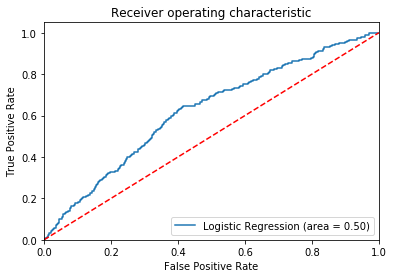

In [434]:
logit_roc_auc = roc_auc_score(y_test, logreg2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# RANDOM FOREST

In [417]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100, random_state=27)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [418]:
clf.score(X_train, y_train)

0.9997916666666666

In [419]:
clf.score(X_test, y_test)

0.8475

In [420]:
y_pred=clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print(f"Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(f"Confusion matrix: \n{metrics.confusion_matrix(y_test, y_pred)}")

Accuracy: 0.8475
Confusion matrix: 
[[2017   59]
 [ 307   17]]


In [421]:
cols = users_adopted_df.columns.tolist()
cols2 = cols[:3] + cols[4:]
cols2

['opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'org_id',
 'creation_timedelta',
 'creation_source_GUEST_INVITE',
 'creation_source_ORG_INVITE',
 'creation_source_PERSONAL_PROJECTS',
 'creation_source_SIGNUP',
 'creation_source_SIGNUP_GOOGLE_AUTH',
 'domain_cuvox.de',
 'domain_gmail.com',
 'domain_gustr.com',
 'domain_hotmail.com',
 'domain_jourrapide.com',
 'domain_other',
 'domain_yahoo.com',
 'invited']

In [422]:
feature_imp = pd.Series(clf.feature_importances_,index=cols2).sort_values(ascending=False)
feature_imp

creation_timedelta                    0.470815
org_id                                0.423838
opted_in_to_mailing_list              0.020713
enabled_for_marketing_drip            0.015275
domain_other                          0.006813
domain_hotmail.com                    0.006778
domain_gmail.com                      0.006645
domain_yahoo.com                      0.006544
creation_source_PERSONAL_PROJECTS     0.006292
domain_jourrapide.com                 0.006186
domain_gustr.com                      0.005762
domain_cuvox.de                       0.005530
creation_source_GUEST_INVITE          0.004822
creation_source_ORG_INVITE            0.004344
creation_source_SIGNUP                0.004295
invited                               0.003183
creation_source_SIGNUP_GOOGLE_AUTH    0.002165
dtype: float64

In [423]:
users_adopted_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_timedelta,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_cuvox.de,domain_gmail.com,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_other,domain_yahoo.com,invited
0,1,0,0.026442,0,0.947874,1,0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0.002404,1,0.731139,0,1,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0.225962,0,0.400549,0,1,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0.002404,0,0.486968,1,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0.463942,0,0.316872,1,0,0,0,0,0,0,0,0,0,0,1,1


No handles with labels found to put in legend.


(0, 0.1)

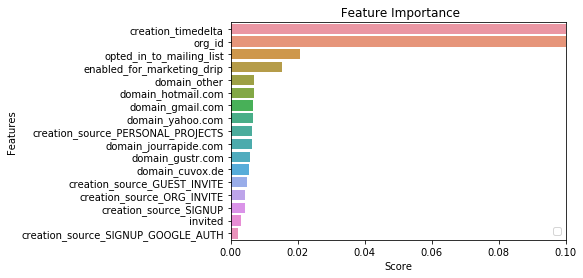

In [433]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Score')
plt.ylabel('Features')
plt.title(" Feature Importance")
plt.legend()
plt.xlim(0, 0.1)

# Summary
Initial tests showed random forest classification performed better than logistic regression for predicting adopted users. Important features identified from the random forest classification include the account creation time, the organization id, and whether the user opted in for the mailing list and marketing drip.